In [1]:
# modules
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

sys.path.append('../')
from baseModels.SVM.model import SVM
from ensemble.model import Ensemble

In [2]:
class Base:
    def __init__(self,SVM=True,GBC=False,NN=False,pca_components=40,regCparam=30,
        kernparam='rbf',nestparam=250,lrateparam=0.01,mdepthparam=5,ssampleparam=1,hlayer=(50,10),
        lrateinit=0.01,regparam=0.1,random_seed=None,optimizeQ=False,verboseQ=False):
        
        self.pca_components=pca_components
        self.optimizeQ=optimizeQ
        self.verboseQ=verboseQ
        self.rs=random_seed
        
        if SVM:
            self.regCparam=regCparam
            self.kernparam=kernparam
            
        elif GBC:
            self.nestparam=nestparam
            self.lrateparam=lrateparam
            self.mdepthparam=mdepthparam


        elif NN:
            self.hlayer=hlayer
            self.lrateparam=lrateinit
            self.reg=regparam

            
        else:
            raise ValueError('No model initiated')
            
    def get_SVM(self,Xtrain,Xtest,ytrain,ytest):
        return SVM(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,regC=self.regCparam,kern=self.kernparam,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)
    
    def get_GBC(self,Xtrain,Xtest,ytrain,ytest):
        return GBC(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,nest=self.nestparam,lrate=self.lrateparam,mdepth=self.mdepthparam,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)

    def get_NN(self,Xtrain,Xtest,ytrain,ytest):
        return NN(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,hlayers=self.hlayer,lrateinit=self.lrateparam,regparam=self.reg,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)


class TEClassification(Base):
    
    def __init__(self,enzseqdata,labelfile,featurefiledirs,model='SVM',random_seed=None,pca_components=55,n_models=17,test_fraction=0.25):
        
        self.random_seed = random_seed
        self.model=model
        self.default_pca_components = pca_components
        self.n_models = n_models
        self.test_fraction = test_fraction
        
        
        #initialize super class
        if self.model=='SVM':
            super().__init__()
        else:
            if self.model=='GBC':
                super().__init__(SVM=False,GBC=True)
            elif self.model=='NN':
                super().__init__(SVM=False,NN=True)
            else:
                raise ValueError('Wrong Model Assigned')
        
        self.object_map = {'SVM':self.get_SVM,'NN':self.get_NN,'GBC':self.get_GBC}
        
        # original data based on which everything is obtained
        df1 = pd.read_csv(enzseqdata,header=None)
        df2 = pd.read_csv(labelfile,header=None)
        self.df = df1.merge(df2,on=0)
        
        self.enz_names = self.df[0].values
        self.X = self.df.iloc[:,1].values
        self.y = self.df.iloc[:,-1].values
        
        # training and testing data for general use
        self.X_train, self.X_test, self.y_train, self.y_test,self.enz_train,self.enz_test = train_test_split(self.X, self.y,self.enz_names, test_size=self.test_fraction, random_state=self.random_seed)
        
        self.label_file = labelfile
        
        #generate a list of names from the directories
        featfiles = [d+f.name for d in featurefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        self.featnames = [f.name.replace('.csv.gz','') for d in featurefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        
        # getting all SVM objects together 
        self.objects = list(map(self.get_model_feat,featfiles))

        
        # select only the best models based on training
        self.best_idx,self.best_models = self.select_top_models(self.objects)
        self.best_model_names = np.array(self.featnames)[self.best_idx]
        
        # getting all model predictions together
        self.all_model_preds = [o.ypredtest for o in self.best_models]
        self.en = Ensemble(self.all_model_preds,self.y_test)
        self.precision = precision_score(self.y_test,self.en.preds,labels=[1],average='micro')
        
        pass
    
    
    def get_model_feat(self,featfilename):
        df1 = pd.read_csv(featfilename,header=None)
        df2 = pd.read_csv(self.label_file,header=None)
        df_feat = df1.merge(df2,on=0).set_index(0)
        df_feat_train = df_feat.loc[self.enz_train]
        df_feat_test = df_feat.loc[self.enz_test]
        X_train_feat,y_train_feat = df_feat_train.iloc[:,0:-1].values,df_feat_train.iloc[:,-1].values
        X_test_feat,y_test_feat = df_feat_test.iloc[:,0:-1].values,df_feat_test.iloc[:,-1].values

        if X_train_feat.shape[1]<self.default_pca_components:
            self.pca_components = int(0.75*X_train_feat.shape[1])
        else:
            self.pca_components=self.default_pca_components
        
        obj = self.object_map[self.model](X_train_feat,X_test_feat,y_train_feat,y_test_feat)
        return obj
        
    def select_top_models(self,Os):
        o_train_accs = [o.acc_train for o in Os]
        sorted_idx = np.argsort(o_train_accs)[::-1]
        best_idx = sorted_idx[:self.n_models]
        return best_idx,np.array(Os)[best_idx]
        

In [3]:
%%time
if __name__=='__main__':
    # Sequence and label files 
    enz_file = '../data/SeqFile/EnzymeSequence.csv'
    label_file = '../data/LabelFiles/EnzymeLabelsBinary.csv'

    # Feature dir for iFeature,kernel,pssm 
    ifeatdatadir = '../featEngg/ifeatMethods/data/featvec/'
    kerneldatadir = '../featEngg/kernelMethods/data/featvec/'
    pssmdatadir = '../featEngg/pssmMethods/data/featvec/'
    featdirs = [ifeatdatadir,kerneldatadir,pssmdatadir]


    te = TEClassification(enz_file,label_file,featdirs,random_seed=7)
    
    def multi_func(rs):
        te_i = TEClassification(enz_file,label_file,featdirs,random_seed=rs)
        return te_i.precision,te_i.en.acc    
    
    pool = mp.Pool(mp.cpu_count())

    
    
    
    metrics = list(pool.map(multi_func,range(10000)))
    


CPU times: user 12.9 s, sys: 843 ms, total: 13.7 s
Wall time: 1h 6min 24s


In [4]:
prec = [acc[0] for acc in metrics]
accs = [acc[1] for acc in metrics]

In [5]:
print(min(prec),np.mean(prec),max(prec),np.std(prec))

0.4 0.8649472509555287 1.0 0.09600250346527835


In [6]:
print(min(accs),np.mean(accs),max(accs),np.std(accs))

0.6206896551724138 0.8757827586206894 1.0 0.058796235228551236


In [7]:
def saveResults(filename):
    with open('../data/SimResults/EnsembleResults/'+filename,'w') as f:
        for rs,score in enumerate(metrics):
            f.write(str(rs)+','+str(score[0])+','+str(score[1])+'\n')
    return

In [8]:
saveResults('BinaryEnsemble.csv')

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   4.,    9.,   41.,  143.,  360.,  832., 1726., 2139., 2988.,
        1758.]),
 array([0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 , 0.76, 0.82, 0.88, 0.94, 1.  ]),
 <BarContainer object of 10 artists>)

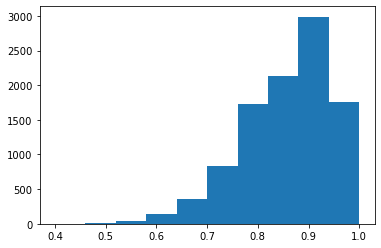

In [10]:
plt.hist(prec)

(array([  12.,   39.,  134.,  332.,  818., 1505., 2140., 2253., 1781.,
         986.]),
 array([0.62068966, 0.65862069, 0.69655172, 0.73448276, 0.77241379,
        0.81034483, 0.84827586, 0.8862069 , 0.92413793, 0.96206897,
        1.        ]),
 <BarContainer object of 10 artists>)

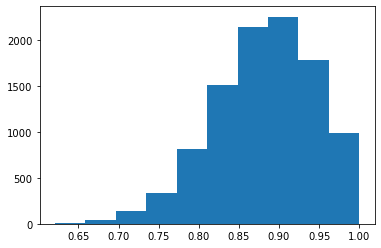

In [11]:
plt.hist(accs)